In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download(handle="nicholasjhana/energy-consumption-generation-prices-and-weather")

print("Path to dataset files:", path)

path_energy = path + "/energy_dataset.csv"
path_weather = path + "/weather_features.csv"

# Load the datasets
import pandas as pd

energy_df = pd.read_csv(path_energy)
# Taking the dataset that was cleaned in the baseline notebook for weather
weather_df = pd.read_csv('./weather_features_binary_cleaned.csv')

c:\Users\rami0\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\rami0\.cache\kagglehub\datasets\nicholasjhana\energy-consumption-generation-prices-and-weather\versions\1
Path to dataset files: C:\Users\rami0\.cache\kagglehub\datasets\nicholasjhana\energy-consumption-generation-prices-and-weather\versions\1


In [2]:
energy_df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [3]:
weather_df.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,...,has_rain,has_drizzle,has_mist,has_fog,has_thunderstorm,has_snow,has_clouds,has_clear,has_haze,has_dust
0,2014-12-31 23:00:00+00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,...,False,False,False,False,False,False,False,True,False,False
1,2015-01-01 00:00:00+00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,...,False,False,False,False,False,False,False,True,False,False
2,2015-01-01 01:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,...,False,False,False,False,False,False,False,True,False,False
3,2015-01-01 02:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,...,False,False,False,False,False,False,False,True,False,False
4,2015-01-01 03:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,...,False,False,False,False,False,False,False,True,False,False


# LE3: Transformieren - Aggregation der Wetterdaten

## Huber/M-Estimator Mean Aggregation

Der Huber-Schätzer ist eine robuste Methode zur Berechnung des Mittelwerts, die weniger empfindlich gegenüber Ausreißern ist als der arithmetische Mittelwert. Er kombiniert die Effizienz des Mittelwerts mit der Robustheit des Medians.

Die Huber-Verlustfunktion ist definiert als:
$$
L_\delta(a) = \begin{cases}
\frac{1}{2}a^2 & \text{für } |a| \leq \delta \\
\delta(|a| - \frac{1}{2}\delta) & \text{sonst}
\end{cases}
$$

Dabei ist $\delta$ der Tuning-Parameter, der bestimmt, ab welchem Punkt die Funktion von quadratisch auf linear wechselt.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import HuberRegressor
from scipy import stats

def huber_mean(data, delta=1.35):
    """
    Calculate the Huber M-estimator mean for a given dataset.
    Uses iteratively reweighted least squares to compute a robust mean.
    
    Parameters:
    -----------
    data : array-like
        The data to compute the robust mean for
    delta : float
        The Huber tuning parameter (default 1.35 for ~95% efficiency)
    
    Returns:
    --------
    float : The Huber M-estimator mean
    """
    data = np.array(data).flatten()
    data = data[~np.isnan(data)]  # Remove NaN values
    
    if len(data) == 0:
        return np.nan
    if len(data) == 1:
        return data[0]
    
    # Use scipy's Huber M-estimator
    try:
        loc, scale = stats.mstats.huber_mean_scale(data, k=delta)
        return loc
    except:
        # Fallback to median if Huber fails
        return np.median(data)

def circular_mean(angles_deg):
    """
    Calculate the circular (angular) mean for wind direction data.
    Wind direction is measured in degrees (0-360), so we need to handle
    the circular nature of the data (e.g., average of 350° and 10° should be 0°, not 180°).
    
    Parameters:
    -----------
    angles_deg : array-like
        Wind direction angles in degrees (0-360)
    
    Returns:
    --------
    float : The circular mean in degrees (0-360)
    """
    angles_deg = np.array(angles_deg).flatten()
    angles_deg = angles_deg[~np.isnan(angles_deg)]
    
    if len(angles_deg) == 0:
        return np.nan
    
    # Convert to radians
    angles_rad = np.deg2rad(angles_deg)
    
    # Calculate mean of sin and cos components
    mean_sin = np.mean(np.sin(angles_rad))
    mean_cos = np.mean(np.cos(angles_rad))
    
    # Calculate circular mean using atan2
    mean_angle_rad = np.arctan2(mean_sin, mean_cos)
    mean_angle_deg = np.rad2deg(mean_angle_rad)
    
    # Ensure result is in [0, 360) range
    if mean_angle_deg < 0:
        mean_angle_deg += 360
    
    return mean_angle_deg

# Test the functions
test_data = [1, 2, 3, 4, 5, 100]  # With outlier
print(f"Test data: {test_data}")
print(f"Arithmetic mean: {np.mean(test_data):.2f}")
print(f"Median: {np.median(test_data):.2f}")
print(f"Huber mean: {huber_mean(test_data):.2f}")

# Test circular mean with wind directions
test_wind = [350, 10, 5, 355]  # Directions around North
print(f"\nWind directions: {test_wind}")
print(f"Arithmetic mean: {np.mean(test_wind):.1f}°")
print(f"Circular mean: {circular_mean(test_wind):.1f}°")
print(f"Huber wind mean: {huber_mean(test_wind):.1f}°")

Test data: [1, 2, 3, 4, 5, 100]
Arithmetic mean: 19.17
Median: 3.50
Huber mean: 3.50

Wind directions: [350, 10, 5, 355]
Arithmetic mean: 180.0°
Circular mean: 360.0°
Huber wind mean: 180.0°


In [5]:
# Compare the dataset wind deg with circular and huber mean.
wind_deg = weather_df['wind_deg'].dropna().values
print(f"\nDataset wind directions (first 10): {wind_deg[:10]}")

print(f"Arithmetic mean: {np.mean(wind_deg):.1f}°")
print(f"Circular mean: {circular_mean(wind_deg):.1f}°")
print(f"Huber wind mean: {huber_mean(wind_deg):.1f}°")    


Dataset wind directions (first 10): [ 62  62  23  23  23 321 321 321 307 307]
Arithmetic mean: 166.7°
Circular mean: 334.0°
Huber wind mean: 178.0°


In [6]:
def aggregate_weather_huber(weather_df, numeric_cols=None, binary_cols=None, circular_cols=None, delta=1.35):
    """
    Aggregate weather data from multiple cities into a single row per timestamp
    using Huber M-estimator mean for robustness against outliers.
    
    Parameters:
    -----------
    weather_df : pd.DataFrame
        Weather dataframe with datetime index and 'city_name' column
    numeric_cols : list, optional
        List of numeric columns to aggregate with Huber mean.
    binary_cols : list, optional
        List of binary columns to aggregate with max (OR logic).
    circular_cols : list, optional
        List of circular columns (e.g., wind_deg) to aggregate with circular mean.
    delta : float
        Huber tuning parameter
    
    Returns:
    --------
    pd.DataFrame : Aggregated weather data with one row per timestamp
    """
    aggregated_parts = []
    
    # Aggregate numeric columns with Huber mean
    if numeric_cols:
        available_numeric = [col for col in numeric_cols if col in weather_df.columns]
        if available_numeric:
            numeric_agg = weather_df.groupby(weather_df.index)[available_numeric].agg(
                lambda x: huber_mean(x.values, delta=delta)
            )
            aggregated_parts.append(numeric_agg)
    
    # Aggregate binary columns with max (OR logic)
    if binary_cols:
        available_binary = [col for col in binary_cols if col in weather_df.columns]
        if available_binary:
            binary_agg = weather_df.groupby(weather_df.index)[available_binary].max()
            aggregated_parts.append(binary_agg)
    
    # Aggregate circular columns with circular mean
    if circular_cols:
        available_circular = [col for col in circular_cols if col in weather_df.columns]
        if available_circular:
            circular_agg = weather_df.groupby(weather_df.index)[available_circular].agg(
                lambda x: circular_mean(x.values)
            )
            aggregated_parts.append(circular_agg)
    
    # Combine all parts
    if aggregated_parts:
        return pd.concat(aggregated_parts, axis=1)
    else:
        # Fallback: aggregate all numeric columns
        numeric_cols = weather_df.select_dtypes(include=[np.number]).columns.tolist()
        return weather_df.groupby(weather_df.index)[numeric_cols].agg(
            lambda x: huber_mean(x.values, delta=delta)
        )

# Define column categories
weather_numeric_cols = ['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 
                        'wind_speed', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all']
weather_binary_cols = ['has_rain', 'has_drizzle', 'has_mist', 'has_fog',
                       'has_thunderstorm', 'has_snow', 'has_clouds', 
                       'has_clear', 'has_haze', 'has_dust']
weather_circular_cols = ['wind_deg']

# Filter to only existing columns
weather_numeric_cols = [col for col in weather_numeric_cols if col in weather_df.columns]
weather_binary_cols = [col for col in weather_binary_cols if col in weather_df.columns]
weather_circular_cols = [col for col in weather_circular_cols if col in weather_df.columns]

print(f"Numeric columns: {weather_numeric_cols}")
print(f"Binary columns: {weather_binary_cols}")
print(f"Circular columns: {weather_circular_cols}")

# Apply Huber aggregation
weather_aggregated = aggregate_weather_huber(
    weather_df, 
    numeric_cols=weather_numeric_cols,
    binary_cols=weather_binary_cols,
    circular_cols=weather_circular_cols
)
print(f"\nOriginal weather data shape: {weather_df.shape}")
print(f"Aggregated weather data shape: {weather_aggregated.shape}")
weather_aggregated.head()

Numeric columns: ['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all']
Binary columns: ['has_rain', 'has_drizzle', 'has_mist', 'has_fog', 'has_thunderstorm', 'has_snow', 'has_clouds', 'has_clear', 'has_haze', 'has_dust']
Circular columns: ['wind_deg']

Original weather data shape: (175320, 28)
Aggregated weather data shape: (175320, 21)

Original weather data shape: (175320, 28)
Aggregated weather data shape: (175320, 21)


,temp,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,rain_3h,snow_3h,clouds_all,...,has_drizzle,has_mist,has_fog,has_thunderstorm,has_snow,has_clouds,has_clear,has_haze,has_dust,wind_deg
0,270.475,270.475,270.475,1001,77,1,0.0,0.0,0.0,0,...,False,False,False,False,False,False,True,False,False,62.0
1,270.475,270.475,270.475,1001,77,1,0.0,0.0,0.0,0,...,False,False,False,False,False,False,True,False,False,62.0
2,269.686,269.686,269.686,1002,78,0,0.0,0.0,0.0,0,...,False,False,False,False,False,False,True,False,False,23.0
3,269.686,269.686,269.686,1002,78,0,0.0,0.0,0.0,0,...,False,False,False,False,False,False,True,False,False,23.0
4,269.686,269.686,269.686,1002,78,0,0.0,0.0,0.0,0,...,False,False,False,False,False,False,True,False,False,23.0


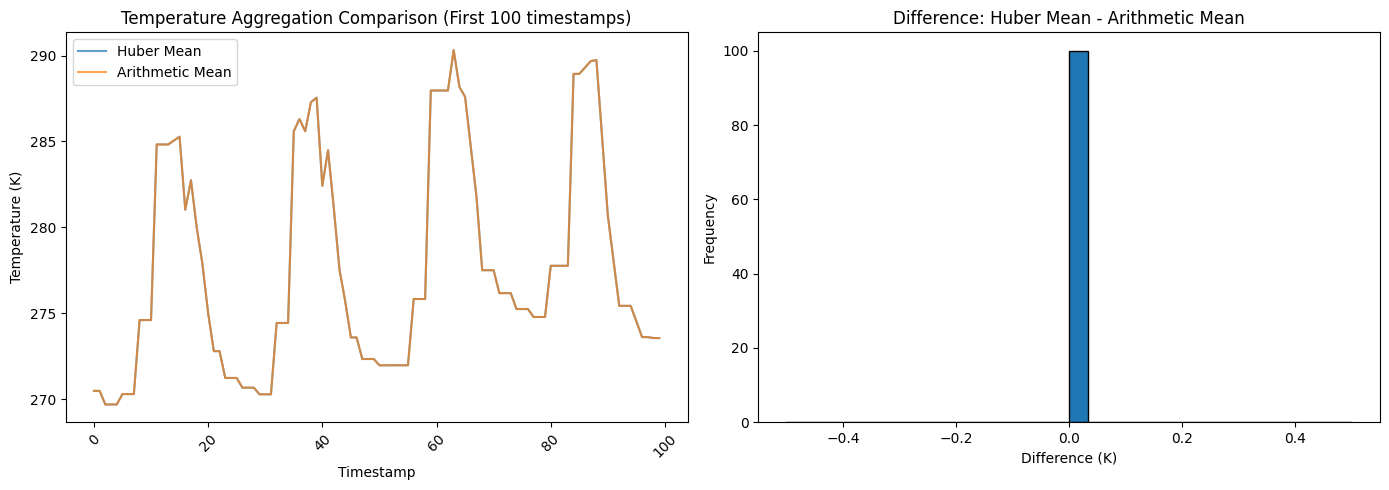

Mean absolute difference: 0.0000 K
Max absolute difference: 0.0000 K


In [7]:
# Compare Huber aggregation with simple mean (baseline)
def aggregate_weather_mean(weather_df, numeric_cols=None):
    """Baseline: Simple arithmetic mean aggregation"""
    if numeric_cols is None:
        numeric_cols = weather_df.select_dtypes(include=[np.number]).columns.tolist()
    return weather_df.groupby(weather_df.index)[numeric_cols].mean()

weather_mean = aggregate_weather_mean(weather_df, numeric_cols=weather_numeric_cols)

# Compare the two aggregation methods
comparison_df = pd.DataFrame({
    'Huber Mean': weather_aggregated['temp'].head(100),
    'Arithmetic Mean': weather_mean['temp'].head(100)
})

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(comparison_df.index, comparison_df['Huber Mean'], label='Huber Mean', alpha=0.7)
plt.plot(comparison_df.index, comparison_df['Arithmetic Mean'], label='Arithmetic Mean', alpha=0.7)
plt.title('Temperature Aggregation Comparison (First 100 timestamps)')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (K)')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
diff = comparison_df['Huber Mean'] - comparison_df['Arithmetic Mean']
plt.hist(diff.dropna(), bins=30, edgecolor='black')
plt.title('Difference: Huber Mean - Arithmetic Mean')
plt.xlabel('Difference (K)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Mean absolute difference: {np.abs(diff).mean():.4f} K")
print(f"Max absolute difference: {np.abs(diff).max():.4f} K")

## Feature Engineering: Lag Features für Zeitreihenanalyse

Für Zeitreihenprognosen erstellen wir Lag-Features (verzögerte Werte) basierend auf verschiedenen Zeitfenstern.

In [8]:
def create_lag_features(df, columns, lags):
    """
    Create lag features for specified columns.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe with datetime index
    columns : list
        Columns to create lag features for
    lags : list of int
        Lag periods in hours (e.g., [1, 24, 168] for 1 hour, 1 day, 1 week)
    
    Returns:
    --------
    pd.DataFrame : DataFrame with added lag features
    """
    df_lagged = df.copy()
    
    for col in columns:
        for lag in lags:
            df_lagged[f'{col}_lag_{lag}h'] = df[col].shift(lag)
    
    return df_lagged

def create_rolling_features(df, columns, windows):
    """
    Create rolling aggregate features (min, max, mean) for specified columns.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe with datetime index
    columns : list
        Columns to create rolling features for
    windows : list of int
        Rolling window sizes in hours
    
    Returns:
    --------
    pd.DataFrame : DataFrame with added rolling features
    """
    df_rolled = df.copy()
    
    for col in columns:
        for window in windows:
            df_rolled[f'{col}_rolling_min_{window}h'] = df[col].rolling(window=window).min()
            df_rolled[f'{col}_rolling_max_{window}h'] = df[col].rolling(window=window).max()
            df_rolled[f'{col}_rolling_mean_{window}h'] = df[col].rolling(window=window).mean()
    
    return df_rolled

# Apply feature engineering to aggregated weather data
lag_periods = [1, 24, 168]  # 1 hour, 1 day, 1 week
rolling_windows = [24, 168]  # 1 day, 1 week

key_weather_cols = ['temp', 'humidity', 'pressure', 'wind_speed']
key_weather_cols = [col for col in key_weather_cols if col in weather_aggregated.columns]

# Create lag features
weather_features = create_lag_features(weather_aggregated, key_weather_cols, lag_periods)

# Create rolling features
weather_features = create_rolling_features(weather_features, ['temp'], rolling_windows)

print(f"Weather features shape after engineering: {weather_features.shape}")
print(f"\nNew columns added:")
new_cols = [col for col in weather_features.columns if col not in weather_aggregated.columns]
print(new_cols)

Weather features shape after engineering: (175320, 39)

New columns added:
['temp_lag_1h', 'temp_lag_24h', 'temp_lag_168h', 'humidity_lag_1h', 'humidity_lag_24h', 'humidity_lag_168h', 'pressure_lag_1h', 'pressure_lag_24h', 'pressure_lag_168h', 'wind_speed_lag_1h', 'wind_speed_lag_24h', 'wind_speed_lag_168h', 'temp_rolling_min_24h', 'temp_rolling_max_24h', 'temp_rolling_mean_24h', 'temp_rolling_min_168h', 'temp_rolling_max_168h', 'temp_rolling_mean_168h']


# LE4: Verknüpfen - Joining Weather and Energy Data

Die Wetter- und Energiedaten werden über den Zeitstempel (Index) verknüpft. Da beide Datensätze stündliche Daten haben, können wir einen direkten Join durchführen.

In [9]:
def join_energy_weather(energy_df, weather_df, how='inner'):
    """
    Join energy and weather dataframes on their datetime index.
    
    Parameters:
    -----------
    energy_df : pd.DataFrame
        Energy consumption dataframe with datetime index
    weather_df : pd.DataFrame
        Aggregated weather dataframe with datetime index
    how : str
        Join type ('inner', 'left', 'right', 'outer')
    
    Returns:
    --------
    pd.DataFrame : Combined dataframe
    """
    # Ensure both indices are datetime
    energy_df.index = pd.to_datetime(energy_df.index)
    weather_df.index = pd.to_datetime(weather_df.index)
    
    # Join on index (timestamp)
    combined_df = energy_df.join(weather_df, how=how, lsuffix='_energy', rsuffix='_weather')
    
    return combined_df

# Join the datasets
combined_df = join_energy_weather(energy_df, weather_features, how='inner')

print(f"Energy data shape: {energy_df.shape}")
print(f"Weather features shape: {weather_features.shape}")
print(f"Combined data shape: {combined_df.shape}")
print(f"\nDate range: {combined_df.index.min()} to {combined_df.index.max()}")
print(f"\nColumns in combined dataset:")
print(combined_df.columns.tolist())

Energy data shape: (35064, 29)
Weather features shape: (175320, 39)
Combined data shape: (35064, 68)

Date range: 1970-01-01 00:00:00 to 1970-01-01 00:00:00.000035063

Columns in combined dataset:
['time', 'generation biomass', 'generation fossil brown coal/lignite', 'generation fossil coal-derived gas', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage aggregated', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation marine', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind offshore', 'generation wind onshore', 'forecast solar day ahead', 'forecast wind offshore eday ahead', 'forecast wind onshore day ahead', 'total load forecast', 'total load actual', 'price day ahead', 'pric

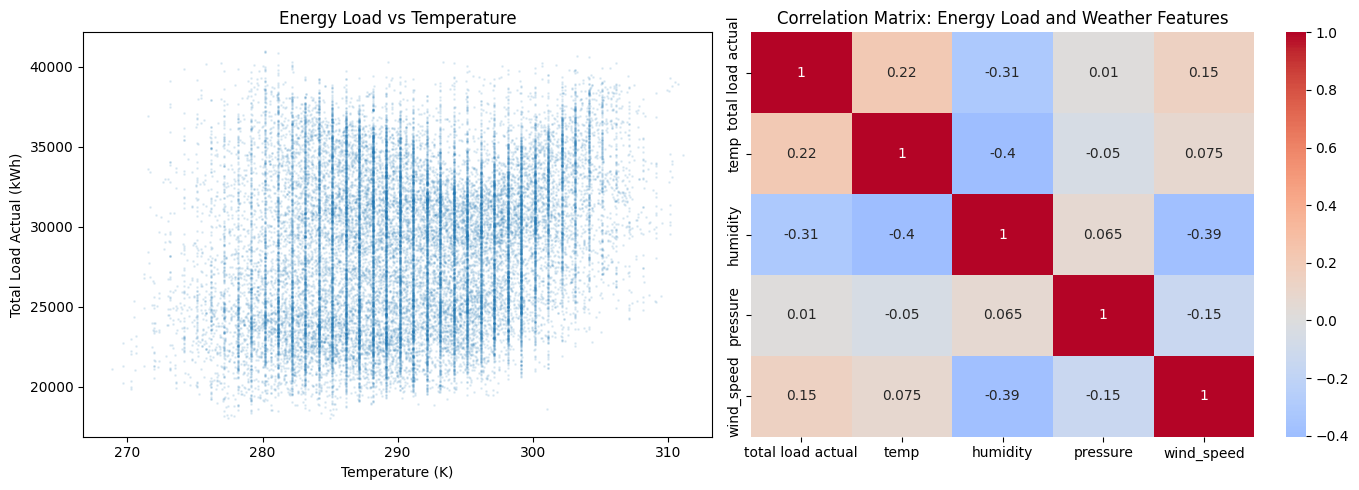


Correlation with Total Load Actual:
total load actual    1.000000
temp                 0.221018
wind_speed           0.147881
pressure             0.010411
humidity            -0.314560
Name: total load actual, dtype: float64


In [10]:
# Visualize the relationship between temperature and energy load
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(combined_df['temp'], combined_df['total load actual'], alpha=0.1, s=1)
plt.xlabel('Temperature (K)')
plt.ylabel('Total Load Actual (kWh)')
plt.title('Energy Load vs Temperature')

plt.subplot(1, 2, 2)
# Calculate correlation
correlation = combined_df[['total load actual', 'temp', 'humidity', 'pressure', 'wind_speed']].corr()
import seaborn as sns
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix: Energy Load and Weather Features')

plt.tight_layout()
plt.show()

print("\nCorrelation with Total Load Actual:")
print(correlation['total load actual'].sort_values(ascending=False))

# LE5: Datenpipelines - Complete Data Wrangling Pipeline

Die gesamte Datenverarbeitung wird in einer modularen Pipeline zusammengefasst, die alle Schritte von Bereinigung bis zur fertigen Feature-Matrix durchführt.

In [11]:
class DataWranglingPipeline:
    """
    Generalized data wrangling pipeline for energy and weather data.
    
    Pipeline Steps:
    1. Load data (LE1: Importieren)
    2. Clean data (LE2: Bereinigen)
    3. Transform/Aggregate weather data (LE3: Transformieren)
    4. Join datasets (LE4: Verknüpfen)
    5. Feature engineering
    
    The pipeline is configurable via constructor parameters for different
    aggregation methods, column selections, and feature engineering options.
    """
    
    def __init__(self, 
                 aggregation_method='huber', 
                 huber_delta=1.35,
                 weather_numeric_cols=None,
                 weather_binary_cols=None,
                 circular_cols=None,
                 key_weather_cols=None,
                 lag_periods=None,
                 rolling_windows=None,
                 target_col='total load actual',
                 energy_time_col='time',
                 weather_time_col='dt_iso'):
        """
        Initialize the pipeline with configuration.
        
        Parameters:
        -----------
        aggregation_method : str
            Method for aggregating weather data ('huber', 'mean', 'median')
        huber_delta : float
            Tuning parameter for Huber estimator (default 1.35 for ~95% efficiency)
        weather_numeric_cols : list, optional
            Numeric columns to aggregate. If None, uses default set.
        weather_binary_cols : list, optional
            Binary columns (e.g., has_rain, has_snow) to aggregate using max (OR logic).
        circular_cols : list, optional
            Circular columns (e.g., wind_deg) that need circular mean.
        key_weather_cols : list, optional
            Key weather columns for lag/rolling features.
        lag_periods : list, optional
            Lag periods in hours for feature engineering.
        rolling_windows : list, optional
            Rolling window sizes in hours for feature engineering.
        target_col : str
            Target column name in energy data.
        energy_time_col : str
            Time column name in energy data.
        weather_time_col : str
            Time column name in weather data.
        """
        self.aggregation_method = aggregation_method
        self.huber_delta = huber_delta
        self.target_col = target_col
        self.energy_time_col = energy_time_col
        self.weather_time_col = weather_time_col
        
        # Default numeric columns for aggregation
        self.weather_numeric_cols = weather_numeric_cols or [
            'temp', 'temp_min', 'temp_max', 'pressure', 
            'humidity', 'wind_speed',
            'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all'
        ]
        
        # Binary columns (aggregated with max = OR logic)
        self.weather_binary_cols = weather_binary_cols or [
            'has_rain', 'has_drizzle', 'has_mist', 'has_fog',
            'has_thunderstorm', 'has_snow', 'has_clouds', 
            'has_clear', 'has_haze', 'has_dust'
        ]
        
        # Circular columns (need circular mean)
        self.circular_cols = circular_cols or ['wind_deg']
        
        # Key columns for lag/rolling features
        self.key_weather_cols = key_weather_cols or ['temp', 'humidity', 'pressure', 'wind_speed']
        
        # Feature engineering parameters
        self.lag_periods = lag_periods if lag_periods is not None else [1, 24, 168]
        self.rolling_windows = rolling_windows if rolling_windows is not None else [24, 168]
        
    def load_data(self, energy_path, weather_path):
        """Step 1: Load raw data from CSV files."""
        print("Step 1: Loading data...")
        energy_df = pd.read_csv(energy_path)
        weather_df = pd.read_csv(weather_path)
        print(f"  Energy data: {energy_df.shape}")
        print(f"  Weather data: {weather_df.shape}")
        return energy_df, weather_df
    
    def clean_data(self, energy_df, weather_df):
        """Step 2: Clean and preprocess data."""
        print("Step 2: Cleaning data...")
        
        energy_df = energy_df.copy()
        weather_df = weather_df.copy()
        
        # Convert datetime columns and set as index
        energy_df[self.energy_time_col] = pd.to_datetime(energy_df[self.energy_time_col], utc=True)
        energy_df = energy_df.set_index(self.energy_time_col)
        
        weather_df[self.weather_time_col] = pd.to_datetime(weather_df[self.weather_time_col], utc=True)
        weather_df = weather_df.set_index(self.weather_time_col)
        
        # Fill missing values in energy data using forecast
        if self.target_col in energy_df.columns:
            forecast_col = self.target_col.replace('actual', 'forecast')
            if forecast_col in energy_df.columns:
                energy_df[self.target_col] = energy_df[self.target_col].fillna(
                    energy_df[forecast_col]
                )
        
        missing_target = energy_df[self.target_col].isna().sum() if self.target_col in energy_df.columns else 'N/A'
        print(f"  Missing values in '{self.target_col}': {missing_target}")
        return energy_df, weather_df
    
    def aggregate_weather(self, weather_df):
        """Step 3: Aggregate weather data from multiple cities."""
        print(f"Step 3: Aggregating weather data using '{self.aggregation_method}' method...")
        
        # Filter to available columns
        available_numeric = [col for col in self.weather_numeric_cols if col in weather_df.columns]
        available_binary = [col for col in self.weather_binary_cols if col in weather_df.columns]
        available_circular = [col for col in self.circular_cols if col in weather_df.columns]
        
        aggregated_parts = []
        
        # Aggregate numeric columns
        if available_numeric:
            if self.aggregation_method == 'huber':
                numeric_agg = weather_df.groupby(weather_df.index)[available_numeric].agg(
                    lambda x: huber_mean(x.values, delta=self.huber_delta)
                )
            elif self.aggregation_method == 'mean':
                numeric_agg = weather_df.groupby(weather_df.index)[available_numeric].mean()
            elif self.aggregation_method == 'median':
                numeric_agg = weather_df.groupby(weather_df.index)[available_numeric].median()
            else:
                raise ValueError(f"Unknown aggregation method: {self.aggregation_method}")
            aggregated_parts.append(numeric_agg)
            print(f"  Aggregated {len(available_numeric)} numeric columns")
        
        # Aggregate binary columns using max (OR logic across cities)
        if available_binary:
            binary_agg = weather_df.groupby(weather_df.index)[available_binary].max()
            aggregated_parts.append(binary_agg)
            print(f"  Aggregated {len(available_binary)} binary columns (using max/OR)")
        
        # Aggregate circular columns using circular mean
        if available_circular:
            circular_agg = weather_df.groupby(weather_df.index)[available_circular].agg(
                lambda x: circular_mean(x.values)
            )
            aggregated_parts.append(circular_agg)
            print(f"  Aggregated {len(available_circular)} circular columns")
        
        # Combine all aggregated parts
        if aggregated_parts:
            aggregated = pd.concat(aggregated_parts, axis=1)
        else:
            raise ValueError("No columns available for aggregation!")
        
        print(f"  Aggregated from {weather_df.shape[0]} rows to {aggregated.shape[0]} rows")
        return aggregated
    
    def engineer_features(self, weather_df):
        """Step 4: Create lag and rolling features."""
        print("Step 4: Engineering features...")
        
        available_key_cols = [col for col in self.key_weather_cols if col in weather_df.columns]
        
        df = weather_df.copy()
        
        # Create lag features
        if self.lag_periods and available_key_cols:
            df = create_lag_features(df, available_key_cols, self.lag_periods)
        
        # Create rolling features for temperature
        if self.rolling_windows and 'temp' in df.columns:
            df = create_rolling_features(df, ['temp'], self.rolling_windows)
        
        new_features = df.shape[1] - weather_df.shape[1]
        print(f"  Added {new_features} new features")
        return df
    
    def join_datasets(self, energy_df, weather_df):
        """Step 5: Join energy and weather data."""
        print("Step 5: Joining datasets...")
        
        combined = join_energy_weather(energy_df, weather_df, how='inner')
        print(f"  Combined shape: {combined.shape}")
        print(f"  Date range: {combined.index.min()} to {combined.index.max()}")
        return combined
    
    def run(self, energy_path, weather_path, drop_na_subset=None):
        """
        Execute the complete pipeline.
        
        Parameters:
        -----------
        energy_path : str
            Path to energy CSV file
        weather_path : str
            Path to weather CSV file
        drop_na_subset : list, optional
            Columns to check for NaN when dropping rows.
            
        Returns:
        --------
        pd.DataFrame : Fully processed and combined dataset
        """
        print("=" * 60)
        print("DATA WRANGLING PIPELINE")
        print(f"Aggregation Method: {self.aggregation_method}")
        print("=" * 60)
        
        # Step 1: Load
        energy_df, weather_df = self.load_data(energy_path, weather_path)
        
        # Step 2: Clean
        energy_df, weather_df = self.clean_data(energy_df, weather_df)
        
        # Step 3: Aggregate weather
        weather_aggregated = self.aggregate_weather(weather_df)
        
        # Step 4: Feature engineering
        weather_features = self.engineer_features(weather_aggregated)
        
        # Step 5: Join
        combined = self.join_datasets(energy_df, weather_features)
        
        # Handle NaN values
        initial_rows = len(combined)
        
        # Skip rows at the beginning due to lag/rolling features
        max_lag = max(self.lag_periods) if self.lag_periods else 0
        max_rolling = max(self.rolling_windows) if self.rolling_windows else 0
        rows_to_skip = max(max_lag, max_rolling)
        
        combined = combined.iloc[rows_to_skip:]
        
        # Drop remaining NaN rows
        if drop_na_subset:
            combined = combined.dropna(subset=drop_na_subset)
        else:
            combined = combined.dropna(subset=[self.target_col])
        
        dropped_rows = initial_rows - len(combined)
        
        print("=" * 60)
        print(f"Pipeline complete! Final dataset: {combined.shape}")
        print(f"Dropped {dropped_rows} rows (first {rows_to_skip} due to lag features)")
        print("=" * 60)
        
        return combined
    
    def get_config(self):
        """Return current pipeline configuration as a dictionary."""
        return {
            'aggregation_method': self.aggregation_method,
            'huber_delta': self.huber_delta,
            'weather_numeric_cols': self.weather_numeric_cols,
            'weather_binary_cols': self.weather_binary_cols,
            'circular_cols': self.circular_cols,
            'key_weather_cols': self.key_weather_cols,
            'lag_periods': self.lag_periods,
            'rolling_windows': self.rolling_windows,
            'target_col': self.target_col
        }

In [12]:
# Run the pipeline with Huber aggregation
# The pipeline automatically detects binary columns from the cleaned weather dataset

pipeline_huber = DataWranglingPipeline(
    aggregation_method='huber', 
    huber_delta=1.35,
    # These will use defaults that include binary columns
)

# Show configuration
print("Pipeline Configuration:")
for key, value in pipeline_huber.get_config().items():
    print(f"  {key}: {value}")
print()

result_huber = pipeline_huber.run(path_energy, path_weather)
result_huber.head()

Pipeline Configuration:
  aggregation_method: huber
  huber_delta: 1.35
  weather_numeric_cols: ['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all']
  weather_binary_cols: ['has_rain', 'has_drizzle', 'has_mist', 'has_fog', 'has_thunderstorm', 'has_snow', 'has_clouds', 'has_clear', 'has_haze', 'has_dust']
  circular_cols: ['wind_deg']
  key_weather_cols: ['temp', 'humidity', 'pressure', 'wind_speed']
  lag_periods: [1, 24, 168]
  rolling_windows: [24, 168]
  target_col: total load actual

DATA WRANGLING PIPELINE
Aggregation Method: huber
Step 1: Loading data...
  Energy data: (35064, 29)
  Weather data: (178396, 17)
Step 2: Cleaning data...
  Missing values in 'total load actual': 0
Step 3: Aggregating weather data using 'huber' method...
  Aggregated 10 numeric columns
  Aggregated 1 circular columns
  Aggregated from 178396 rows to 35064 rows
Step 4: Engineering features...
  Added 18 new features
Step 5: Joining dataset

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,pressure_lag_168h,wind_speed_lag_1h,wind_speed_lag_24h,wind_speed_lag_168h,temp_rolling_min_24h,temp_rolling_max_24h,temp_rolling_mean_24h,temp_rolling_min_168h,temp_rolling_max_168h,temp_rolling_mean_168h
time,,,,,,,,,,,,,,,,,,,,,
2015-01-07 23:00:00+00:00,546.0,571.0,0.0,4178.0,7280.0,383.0,0.0,0.0,0.0,NaN,...,1035.0,1.0,1.0,1.0,275.712,284.403313,279.143828,269.686,289.492,278.144107
2015-01-08 00:00:00+00:00,516.0,566.0,0.0,3912.0,6774.0,370.0,0.0,0.0,0.0,NaN,...,1035.0,1.0,1.0,1.0,275.712,284.403313,279.149620,269.686,289.492,278.182381
2015-01-08 01:00:00+00:00,508.0,455.0,0.0,3718.0,6349.0,372.0,0.0,0.0,0.0,NaN,...,1036.0,1.0,1.0,1.0,275.712,284.403313,279.164203,269.686,289.492,278.223839
2015-01-08 02:00:00+00:00,509.0,369.0,0.0,3768.0,6078.0,373.0,0.0,0.0,0.0,NaN,...,1035.0,1.0,1.0,1.0,275.712,284.403313,279.178786,269.686,289.492,278.265297
2015-01-08 03:00:00+00:00,518.0,367.0,0.0,3707.0,5984.0,373.0,0.0,0.0,0.0,NaN,...,1035.0,1.0,1.0,1.0,275.712,284.403313,279.193370,270.292,289.492,278.306756


In [13]:
# Compare pipeline results with different aggregation methods
pipeline_mean = DataWranglingPipeline(aggregation_method='mean')
result_mean = pipeline_mean.run(path_energy, path_weather)

pipeline_median = DataWranglingPipeline(aggregation_method='median')
result_median = pipeline_median.run(path_energy, path_weather)

# Compare the results
print("\n" + "=" * 60)
print("AGGREGATION METHOD COMPARISON")
print("=" * 60)

methods = ['Huber', 'Mean', 'Median']
results = [result_huber, result_mean, result_median]

for method, result in zip(methods, results):
    print(f"\n{method} Aggregation:")
    print(f"  Temperature mean: {result['temp'].mean():.2f} K")
    print(f"  Temperature std: {result['temp'].std():.2f} K")
    print(f"  Total Load mean: {result['total load actual'].mean():.2f} kWh")

DATA WRANGLING PIPELINE
Aggregation Method: mean
Step 1: Loading data...
  Energy data: (35064, 29)
  Weather data: (178396, 17)
Step 2: Cleaning data...
  Missing values in 'total load actual': 0
Step 3: Aggregating weather data using 'mean' method...
  Aggregated 10 numeric columns
  Aggregated 1 circular columns
  Aggregated from 178396 rows to 35064 rows
Step 4: Engineering features...
  Added 18 new features
Step 5: Joining datasets...
  Combined shape: (35064, 57)
  Date range: 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Pipeline complete! Final dataset: (34896, 57)
Dropped 168 rows (first 168 due to lag features)
DATA WRANGLING PIPELINE
Aggregation Method: median
Step 1: Loading data...
  Energy data: (35064, 29)
  Weather data: (178396, 17)
Step 2: Cleaning data...
  Missing values in 'total load actual': 0
Step 3: Aggregating weather data using 'median' method...
  Aggregated 10 numeric columns
  Aggregated 1 circular columns
  Aggregated from 178396 rows to 35064 r

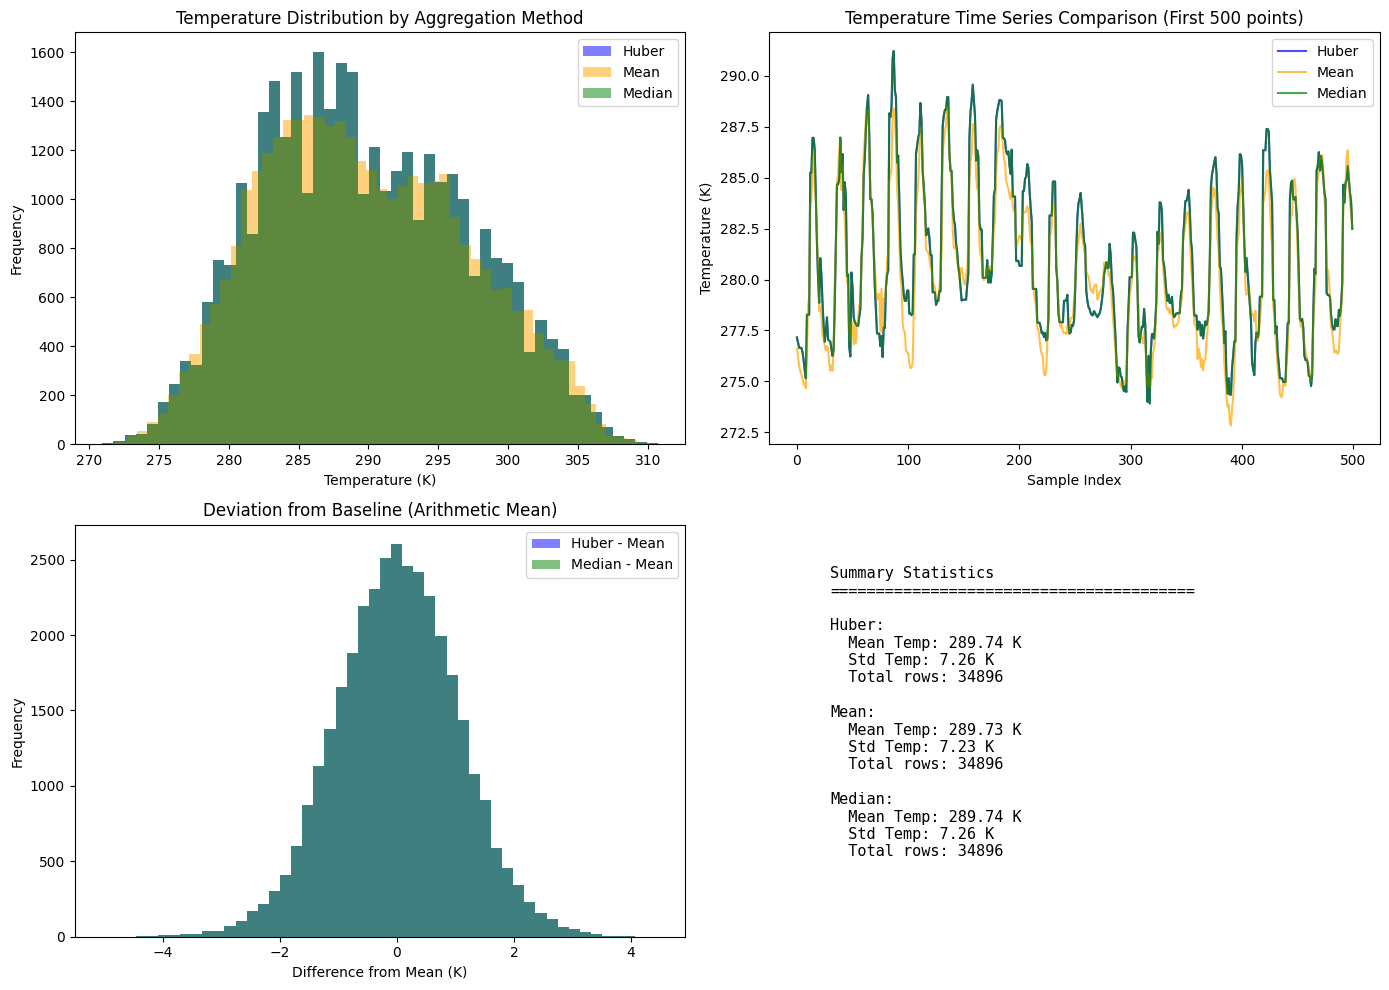

In [14]:
# Visualize comparison of aggregation methods
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Temperature distribution comparison
ax1 = axes[0, 0]
for method, result, color in zip(methods, results, ['blue', 'orange', 'green']):
    ax1.hist(result['temp'], bins=50, alpha=0.5, label=method, color=color)
ax1.set_xlabel('Temperature (K)')
ax1.set_ylabel('Frequency')
ax1.set_title('Temperature Distribution by Aggregation Method')
ax1.legend()

# Temperature time series (first 500 points)
ax2 = axes[0, 1]
sample_size = 500
for method, result, color in zip(methods, results, ['blue', 'orange', 'green']):
    ax2.plot(result['temp'].iloc[:sample_size].values, label=method, alpha=0.7, color=color)
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('Temperature (K)')
ax2.set_title('Temperature Time Series Comparison (First 500 points)')
ax2.legend()

# Difference from baseline (mean)
ax3 = axes[1, 0]
huber_diff = result_huber['temp'] - result_mean['temp']
median_diff = result_median['temp'] - result_mean['temp']
ax3.hist(huber_diff.dropna(), bins=50, alpha=0.5, label='Huber - Mean', color='blue')
ax3.hist(median_diff.dropna(), bins=50, alpha=0.5, label='Median - Mean', color='green')
ax3.set_xlabel('Difference from Mean (K)')
ax3.set_ylabel('Frequency')
ax3.set_title('Deviation from Baseline (Arithmetic Mean)')
ax3.legend()

# Summary statistics
ax4 = axes[1, 1]
ax4.axis('off')
summary_text = "Summary Statistics\n" + "=" * 40 + "\n\n"
for method, result in zip(methods, results):
    summary_text += f"{method}:\n"
    summary_text += f"  Mean Temp: {result['temp'].mean():.2f} K\n"
    summary_text += f"  Std Temp: {result['temp'].std():.2f} K\n"
    summary_text += f"  Total rows: {len(result)}\n\n"
ax4.text(0.1, 0.9, summary_text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

In [15]:
# Save the final processed dataset
output_path = "processed_energy_weather_huber.csv"
result_huber.to_csv(output_path)
print(f"Processed dataset saved to: {output_path}")
print(f"Final dataset shape: {result_huber.shape}")
print(f"\nColumn summary:")
print(f"  - Energy features: {len([c for c in result_huber.columns if 'load' in c or 'generation' in c or 'price' in c])}")
print(f"  - Weather features: {len([c for c in result_huber.columns if any(w in c for w in ['temp', 'humidity', 'pressure', 'wind', 'rain', 'snow', 'clouds'])])}")
print(f"  - Lag features: {len([c for c in result_huber.columns if 'lag' in c])}")
print(f"  - Rolling features: {len([c for c in result_huber.columns if 'rolling' in c])}")

Processed dataset saved to: processed_energy_weather_huber.csv
Final dataset shape: (34896, 57)

Column summary:
  - Energy features: 25
  - Weather features: 33
  - Lag features: 12
  - Rolling features: 6


## Statsmodels Comparison: Energy Forecasting with Different Aggregation Methods

We compare the forecasting performance of OLS regression models trained on data aggregated with Huber mean vs. arithmetic mean.

In [16]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def prepare_forecast_data(df, target_col='total load actual', feature_cols=None):
    """
    Prepare data for forecasting by selecting features and handling NaN.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Combined energy-weather dataset
    target_col : str
        Target variable to predict
    feature_cols : list, optional
        Feature columns to use. If None, uses weather features.
    
    Returns:
    --------
    X, y : DataFrames for features and target
    """
    if feature_cols is None:
        # Use weather-related features
        feature_cols = [col for col in df.columns if any(w in col for w in 
                       ['temp', 'humidity', 'pressure', 'wind_speed']) 
                       and col != target_col]
    
    # Filter to existing columns
    feature_cols = [col for col in feature_cols if col in df.columns]
    
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    
    # Drop rows with NaN
    mask = ~(X.isna().any(axis=1) | y.isna())
    X = X[mask]
    y = y[mask]
    
    return X, y, feature_cols

def train_ols_model(X_train, y_train, X_test, y_test):
    """
    Train an OLS regression model and return metrics.
    """
    # Add constant for intercept
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)
    
    # Fit OLS model
    model = sm.OLS(y_train, X_train_const).fit()
    
    # Predictions
    y_pred_train = model.predict(X_train_const)
    y_pred_test = model.predict(X_test_const)
    
    # Metrics
    metrics = {
        'R2_train': r2_score(y_train, y_pred_train),
        'R2_test': r2_score(y_test, y_pred_test),
        'RMSE_train': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'RMSE_test': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'MAE_train': mean_absolute_error(y_train, y_pred_train),
        'MAE_test': mean_absolute_error(y_test, y_pred_test),
        'AIC': model.aic,
        'BIC': model.bic
    }
    
    return model, metrics, y_pred_test

print("Forecast comparison functions defined.")

Forecast comparison functions defined.


In [17]:
# Run pipelines and compare forecasting performance
print("Running pipelines with fixed NaN handling...")
print()

# Run Huber pipeline
pipeline_huber = DataWranglingPipeline(aggregation_method='huber', huber_delta=1.35)
result_huber = pipeline_huber.run(path_energy, path_weather)

print()

# Run Mean pipeline
pipeline_mean = DataWranglingPipeline(aggregation_method='mean')
result_mean = pipeline_mean.run(path_energy, path_weather)

print()

# Run Median pipeline
pipeline_median = DataWranglingPipeline(aggregation_method='median')
result_median = pipeline_median.run(path_energy, path_weather)

print(f"\nFinal dataset sizes:")
print(f"  Huber: {result_huber.shape}")
print(f"  Mean: {result_mean.shape}")
print(f"  Median: {result_median.shape}")

Running pipelines with fixed NaN handling...

DATA WRANGLING PIPELINE
Aggregation Method: huber
Step 1: Loading data...
  Energy data: (35064, 29)
  Weather data: (178396, 17)
Step 2: Cleaning data...
  Missing values in 'total load actual': 0
Step 3: Aggregating weather data using 'huber' method...
  Aggregated 10 numeric columns
  Aggregated 1 circular columns
  Aggregated from 178396 rows to 35064 rows
Step 4: Engineering features...
  Added 18 new features
Step 5: Joining datasets...
  Combined shape: (35064, 57)
  Date range: 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Pipeline complete! Final dataset: (34896, 57)
Dropped 168 rows (first 168 due to lag features)

DATA WRANGLING PIPELINE
Aggregation Method: mean
Step 1: Loading data...
  Energy data: (35064, 29)
  Weather data: (178396, 17)
Step 2: Cleaning data...
  Missing values in 'total load actual': 0
Step 3: Aggregating weather data using 'mean' method...
  Aggregated 10 numeric columns
  Aggregated 1 circular col

In [18]:
# Train and compare OLS models for each aggregation method
results_comparison = {}

# Define feature columns to use (base weather features + some lag features)
feature_cols = ['temp', 'humidity', 'pressure', 'wind_speed',
                'temp_lag_1h', 'temp_lag_24h', 'temp_lag_168h',
                'temp_rolling_mean_24h', 'temp_rolling_mean_168h']

for method, result_df in [('Huber', result_huber), ('Mean', result_mean), ('Median', result_median)]:
    print(f"\n{'='*60}")
    print(f"Training OLS model with {method} aggregation")
    print(f"{'='*60}")
    
    # Prepare data
    X, y, used_features = prepare_forecast_data(result_df, feature_cols=feature_cols)
    print(f"Features used: {used_features}")
    print(f"Sample size: {len(X)}")
    
    # Train/test split (80/20, preserving time order)
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    
    # Train model
    model, metrics, y_pred = train_ols_model(X_train, y_train, X_test, y_test)
    
    results_comparison[method] = {
        'model': model,
        'metrics': metrics,
        'y_test': y_test,
        'y_pred': y_pred
    }
    
    print(f"\nModel Performance:")
    print(f"  R² (test): {metrics['R2_test']:.4f}")
    print(f"  RMSE (test): {metrics['RMSE_test']:.2f} kWh")
    print(f"  MAE (test): {metrics['MAE_test']:.2f} kWh")
    print(f"  AIC: {metrics['AIC']:.2f}")
    print(f"  BIC: {metrics['BIC']:.2f}")


Training OLS model with Huber aggregation
Features used: ['temp', 'humidity', 'pressure', 'wind_speed', 'temp_lag_1h', 'temp_lag_24h', 'temp_lag_168h', 'temp_rolling_mean_24h', 'temp_rolling_mean_168h']
Sample size: 34896
Train size: 27916, Test size: 6980

Model Performance:
  R² (test): 0.2577
  RMSE (test): 3893.15 kWh
  MAE (test): 3222.69 kWh
  AIC: 542460.70
  BIC: 542543.07

Training OLS model with Mean aggregation
Features used: ['temp', 'humidity', 'pressure', 'wind_speed', 'temp_lag_1h', 'temp_lag_24h', 'temp_lag_168h', 'temp_rolling_mean_24h', 'temp_rolling_mean_168h']
Sample size: 34896
Train size: 27916, Test size: 6980

Model Performance:
  R² (test): 0.2769
  RMSE (test): 3842.40 kWh
  MAE (test): 3170.29 kWh
  AIC: 541578.63
  BIC: 541661.00

Training OLS model with Median aggregation
Features used: ['temp', 'humidity', 'pressure', 'wind_speed', 'temp_lag_1h', 'temp_lag_24h', 'temp_lag_168h', 'temp_rolling_mean_24h', 'temp_rolling_mean_168h']
Sample size: 34896
Train s

In [19]:
# Create comparison summary table
print("\n" + "=" * 80)
print("AGGREGATION METHOD COMPARISON - FORECASTING PERFORMANCE")
print("=" * 80)

comparison_table = pd.DataFrame({
    method: {
        'R² (test)': data['metrics']['R2_test'],
        'RMSE (test)': data['metrics']['RMSE_test'],
        'MAE (test)': data['metrics']['MAE_test'],
        'AIC': data['metrics']['AIC'],
        'BIC': data['metrics']['BIC']
    }
    for method, data in results_comparison.items()
}).T

print("\nMetrics Summary:")
print(comparison_table.to_string())

# Identify best method for each metric
print("\n" + "-" * 40)
print("Best Method by Metric:")
print("-" * 40)
print(f"  Highest R²: {comparison_table['R² (test)'].idxmax()} ({comparison_table['R² (test)'].max():.4f})")
print(f"  Lowest RMSE: {comparison_table['RMSE (test)'].idxmin()} ({comparison_table['RMSE (test)'].min():.2f} kWh)")
print(f"  Lowest MAE: {comparison_table['MAE (test)'].idxmin()} ({comparison_table['MAE (test)'].min():.2f} kWh)")
print(f"  Lowest AIC: {comparison_table['AIC'].idxmin()} ({comparison_table['AIC'].min():.2f})")
print(f"  Lowest BIC: {comparison_table['BIC'].idxmin()} ({comparison_table['BIC'].min():.2f})")


AGGREGATION METHOD COMPARISON - FORECASTING PERFORMANCE

Metrics Summary:
        R² (test)  RMSE (test)   MAE (test)            AIC            BIC
Huber    0.257682  3893.146862  3222.689463  542460.695956  542543.065509
Mean     0.276907  3842.403807  3170.286416  541578.633957  541661.003509
Median   0.257682  3893.146862  3222.689463  542460.695956  542543.065509

----------------------------------------
Best Method by Metric:
----------------------------------------
  Highest R²: Mean (0.2769)
  Lowest RMSE: Mean (3842.40 kWh)
  Lowest MAE: Mean (3170.29 kWh)
  Lowest AIC: Mean (541578.63)
  Lowest BIC: Mean (541661.00)


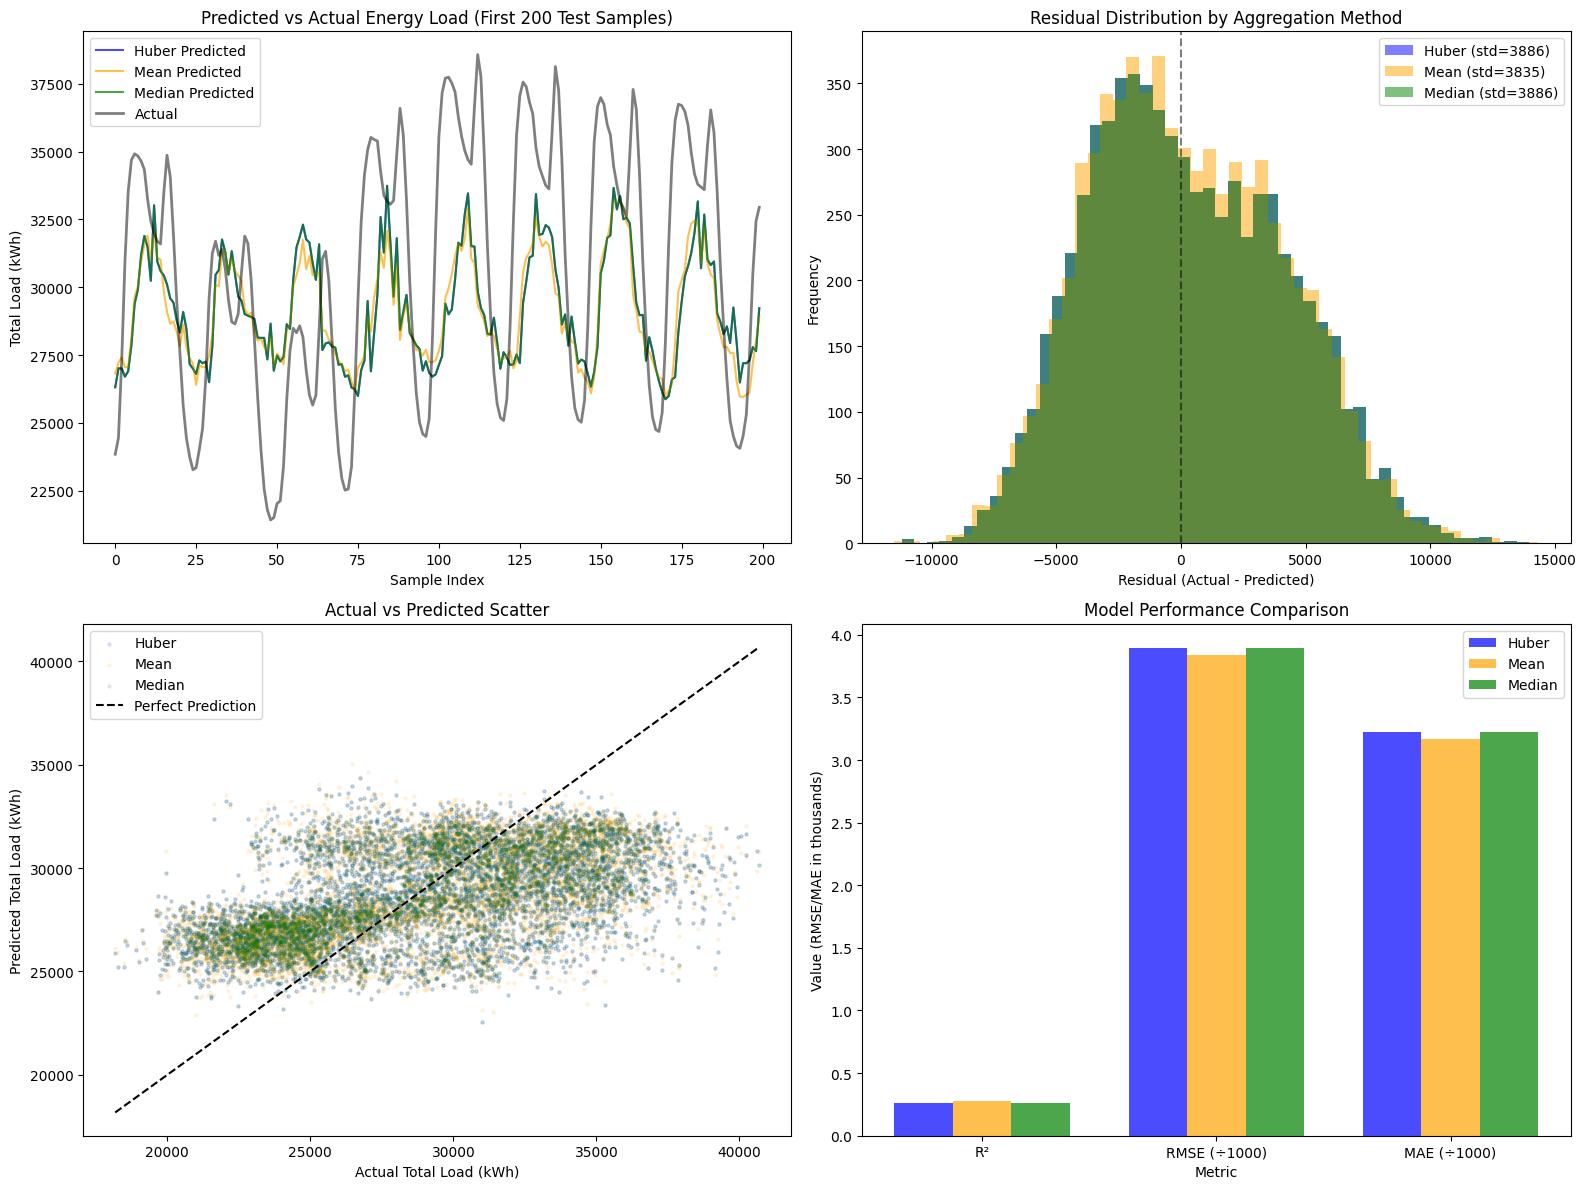

In [20]:
# Visualize forecasting comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Actual vs Predicted for each method (sample)
ax1 = axes[0, 0]
sample_size = 200
for method, color in [('Huber', 'blue'), ('Mean', 'orange'), ('Median', 'green')]:
    y_test = results_comparison[method]['y_test'].iloc[:sample_size]
    y_pred = results_comparison[method]['y_pred'].iloc[:sample_size]
    ax1.plot(range(sample_size), y_pred, label=f'{method} Predicted', alpha=0.7, color=color)
ax1.plot(range(sample_size), y_test.values, label='Actual', color='black', linewidth=2, alpha=0.5)
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Total Load (kWh)')
ax1.set_title('Predicted vs Actual Energy Load (First 200 Test Samples)')
ax1.legend()

# Plot 2: Residuals distribution
ax2 = axes[0, 1]
for method, color in [('Huber', 'blue'), ('Mean', 'orange'), ('Median', 'green')]:
    residuals = results_comparison[method]['y_test'].values - results_comparison[method]['y_pred'].values
    ax2.hist(residuals, bins=50, alpha=0.5, label=f'{method} (std={np.std(residuals):.0f})', color=color)
ax2.set_xlabel('Residual (Actual - Predicted)')
ax2.set_ylabel('Frequency')
ax2.set_title('Residual Distribution by Aggregation Method')
ax2.legend()
ax2.axvline(x=0, color='black', linestyle='--', alpha=0.5)

# Plot 3: Scatter plot - Actual vs Predicted
ax3 = axes[1, 0]
for method, color, marker in [('Huber', 'blue', 'o'), ('Mean', 'orange', 's'), ('Median', 'green', '^')]:
    y_test = results_comparison[method]['y_test'].values
    y_pred = results_comparison[method]['y_pred'].values
    ax3.scatter(y_test, y_pred, alpha=0.1, s=5, color=color, label=method)
# Perfect prediction line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
ax3.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')
ax3.set_xlabel('Actual Total Load (kWh)')
ax3.set_ylabel('Predicted Total Load (kWh)')
ax3.set_title('Actual vs Predicted Scatter')
ax3.legend()

# Plot 4: Bar chart comparison of metrics
ax4 = axes[1, 1]
metrics_to_plot = ['R² (test)', 'RMSE (test)', 'MAE (test)']
x = np.arange(len(metrics_to_plot))
width = 0.25

# Normalize RMSE and MAE for visualization
normalized_table = comparison_table.copy()
normalized_table['RMSE (test)'] = comparison_table['RMSE (test)'] / 1000
normalized_table['MAE (test)'] = comparison_table['MAE (test)'] / 1000

for i, (method, color) in enumerate([('Huber', 'blue'), ('Mean', 'orange'), ('Median', 'green')]):
    values = [normalized_table.loc[method, m] for m in metrics_to_plot]
    ax4.bar(x + i*width, values, width, label=method, color=color, alpha=0.7)

ax4.set_xlabel('Metric')
ax4.set_ylabel('Value (RMSE/MAE in thousands)')
ax4.set_title('Model Performance Comparison')
ax4.set_xticks(x + width)
ax4.set_xticklabels(['R²', 'RMSE (÷1000)', 'MAE (÷1000)'])
ax4.legend()

plt.tight_layout()
plt.show()

In [21]:
print(results_comparison['Huber']['model'].summary())

                            OLS Regression Results                            
Dep. Variable:      total load actual   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     958.1
Date:                Tue, 09 Dec 2025   Prob (F-statistic):               0.00
Time:                        11:06:07   Log-Likelihood:            -2.7122e+05
No. Observations:               27916   AIC:                         5.425e+05
Df Residuals:                   27906   BIC:                         5.425e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   4.68